<a href="https://colab.research.google.com/github/KhondamirRustamov/bioinformatics301/blob/main/Vina_Basic_Docking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

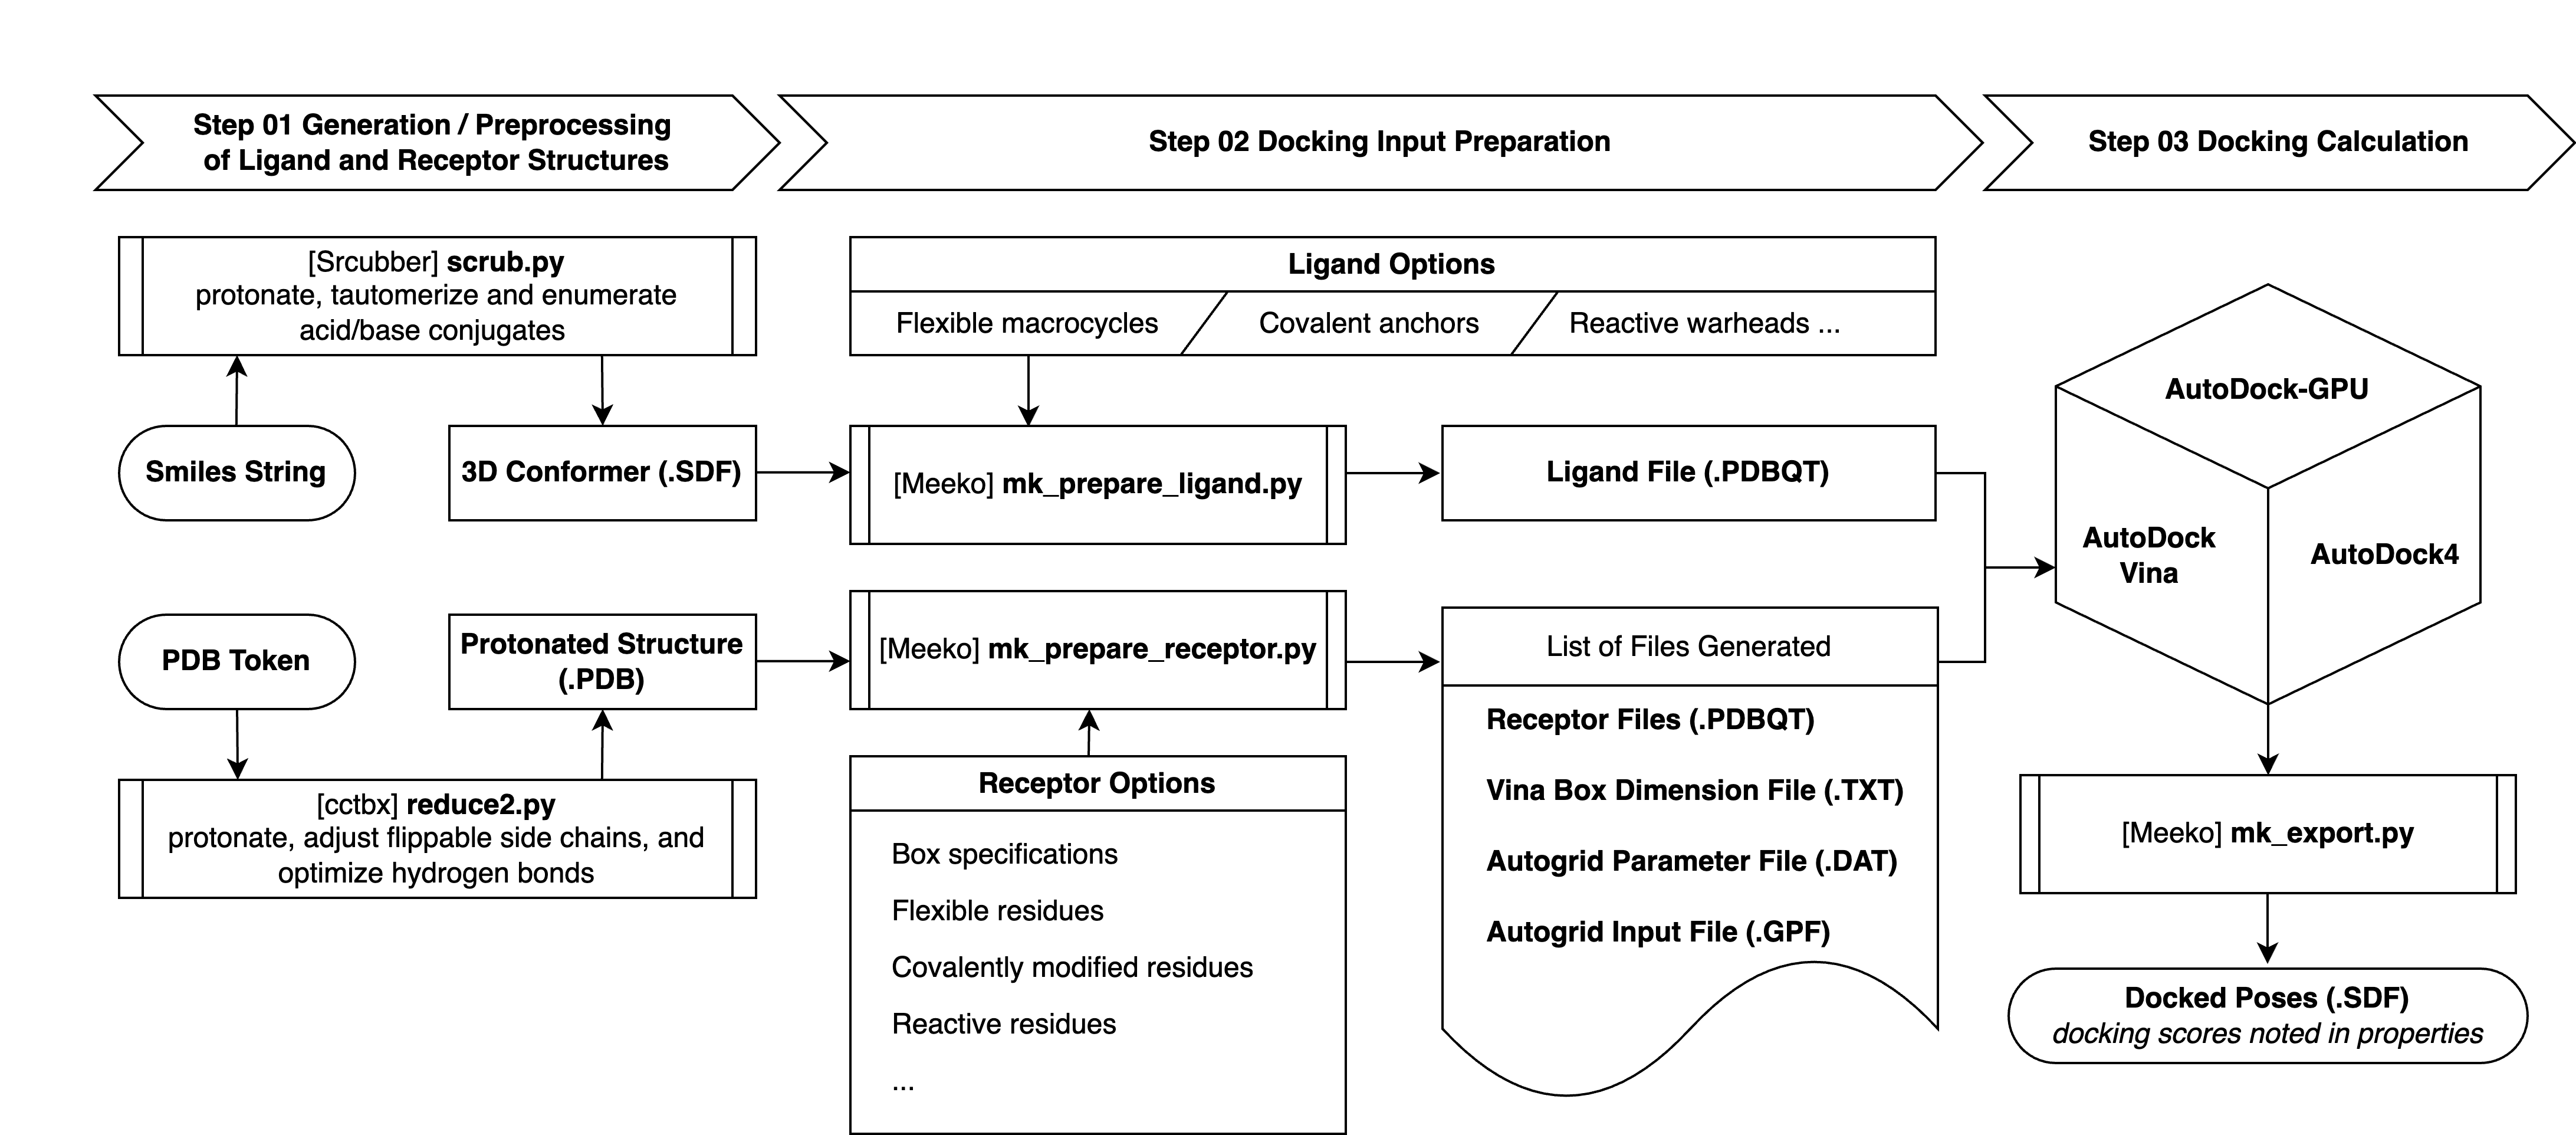

# Overview of This Example: Basic Docking

> This Colab notebook is currently indexed in:
*   AutoDock-Vina Documentation - [Colab Examples](https://autodock-vina.readthedocs.io/en/latest/colab_examples.html)
*   Meeko Documentation - [Colab Examples](https://meeko.readthedocs.io/en/release-doc/colab_examples.html)
*   RSD3 Training Resource - [Training Resource](https://rsd3.scripps.edu/training/)

> **Subscription is NOT required** to run these Colab examples.

This is a **basic docking** example that uses the AutoDock Vina executable to run a basic docking of a flexible small drug-like molecule onto a rigid protein receptor.

The basic docking example is a rewrite based on the original basic docking example. In this example, a small molecule ligand (Imatinib, PDB token STI) is docked back to a hollow protein structure of mouse c-Abl (PDB token 1IEP) to reproduce the complex structure. A docked pose that closely resembles the original position of the ligand is expected among the top-ranked poses.


## Colab Tips

* To make an **editable copy** of this notebook: Navigate to the top menu bar, File > Save a copy.
* You must **connect to a runtime first** to execute the code blocks. Use the top menu bar to manage your runtime and sessions.
* To **execute** each code block: Use the Play button on the left.
* To see the **table of contents** and **access files in directory**: Use the left hand side panel.


# Environment Setup

In these steps, a Python environment is prepared for you to run this example.

*Major Python packages used*

- RDKit https://rdkit.org/
- Molscrub https://github.com/forlilab/molscrub
- Meeko https://github.com/forlilab/Meeko
- ProDy http://www.bahargroup.org/prody/
- cctbx-base (for reduce2) https://github.com/cctbx/cctbx_project
- py3Dmol https://3dmol.org/

*Data*

- Phenix-project/geostd (for reduce2) https://github.com/phenix-project/geostd/

In [1]:
# @title (1) Install Condacolab (< 1min)
%%time

! pip install -q condacolab
import condacolab
condacolab.install()

#@markdown > An automatic restart of the kernel is expected after the execution of this block.
#@markdown >
#@markdown > Stay connected to the same runtime and proceed to the next code block!


⏬ Downloading https://github.com/jaimergp/miniforge/releases/download/24.11.2-1_colab/Miniforge3-colab-24.11.2-1_colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:16
🔁 Restarting kernel...
CPU times: user 601 ms, sys: 251 ms, total: 852 ms
Wall time: 24.4 s


In [1]:
# @title (2) Install Packages and Data (~ 2min)
%%time

# Get environment configuration from Git Repository
setup_repo="https://github.com/rwxayheee/colab_setup"
!git clone {setup_repo}

# Run setup script
!chmod +x colab_setup/basic_setup.sh
!bash colab_setup/basic_setup.sh

Cloning into 'colab_setup'...
remote: Enumerating objects: 63, done.
remote: Counting objects: 100% (63/63), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 63 (delta 24), reused 45 (delta 16), pack-reused 0 (from 0)
Receiving objects: 100% (63/63), 11.99 KiB | 1.50 MiB/s, done.
Resolving deltas: 100% (24/24), done.

[INFO] Step 1: Installing Python packages using Conda and Pip...

Channels:
 - conda-forge
Platform: linux-64
Solving environment: | / - \ | / - done

cctbx-base-2024.8    | 66.8 MB   | :   0% 0/1 [00:00<?, ?it/s]
pillow-11.1.0        | 40.1 MB   | :   0% 0/1 [00:00<?, ?it/s]

librdkit-2024.03.6   | 20.1 MB   | :   0% 0/1 [00:00<?, ?it/s]


scipy-1.15.1         | 18.3 MB   | :   0% 0/1 [00:00<?, ?it/s]



pandas-2.2.3         | 15.0 MB   | :   0% 0/1 [00:00<?, ?it/s]




prody-2.4.1          | 13.8 MB   | :   0% 0/1 [00:00<?, ?it/s]





icu-75.1             | 11.6 MB   | :   0% 0/1 [00:00<?, ?it/s]






matplotlib-base-3.10 | 8.1 MB    

In [5]:
# @title (3) Import Modules & Locate Command Line Scripts (< 1s)
%%time
!pip install mdanalysis
# Import modules
import sys, platform
from prody import *
from pathlib import Path
from rdkit import Chem
from rdkit.Chem import AllChem
import rdkit, py3Dmol
print("rdkit version:", rdkit.__version__)
print("py3Dmol version:", py3Dmol.__version__)
from ipywidgets import interact, IntSlider
import ipywidgets, copy
from IPython.display import display, Markdown
import MDAnalysis as mda

# Helper functions
def locate_file(from_path = None, query_path = None, query_name = "query file"):

    if not from_path or not query_path:
        raise ValueError("Must specify from_path and query_path")

    possible_path = list(from_path.glob(query_path))

    if not possible_path:
        raise FileNotFoundError(f"Cannot find {query_name} from {from_path} by {query_path}")

    return_which = (
        f"using {query_name} at:\n"
        f"{possible_path[0]}\n"
    )
    print(return_which)

    return possible_path[0]


# Commandline scripts
scrub = locate_file(from_path = Path("/usr/local/bin"), query_path = "scrub.py", query_name = "scrub.py")
mk_prepare_ligand = locate_file(from_path = Path("/usr/local/bin"), query_path = "mk_prepare_ligand.py", query_name = "mk_prepare_ligand.py")
mk_prepare_receptor = locate_file(from_path = Path("/usr/local/bin"), query_path = "mk_prepare_receptor.py", query_name = "mk_prepare_receptor.py")
mk_export = locate_file(from_path = Path("/usr/local/bin"), query_path = "mk_export.py", query_name = "mk_export.py")


# Locate reduce2 in conda install prefix
full_py_version = platform.python_version()
major_and_minor = ".".join(full_py_version.split(".")[:2])
env_path = Path("/usr/local") # default conda install prefix on Colab
reduce2_path = f"lib/python{major_and_minor}/site-packages/mmtbx/command_line/reduce2.py"
reduce2 = locate_file(from_path = env_path, query_path = reduce2_path, query_name = "reduce2.py")


# Locate geostd in current path
geostd_path = locate_file(from_path = Path.cwd(), query_path = "geostd", query_name = "geostd")

#@markdown > Version of imported modules and the location of command line scripts will be reported to output.
#@markdown >
#@markdown > Make sure there are no errors and proceed to the next code block!


rdkit version: 2024.03.6
py3Dmol version: 2.4.2
using scrub.py at:
/usr/local/bin/scrub.py

using mk_prepare_ligand.py at:
/usr/local/bin/mk_prepare_ligand.py

using mk_prepare_receptor.py at:
/usr/local/bin/mk_prepare_receptor.py

using mk_export.py at:
/usr/local/bin/mk_export.py

using reduce2.py at:
/usr/local/lib/python3.11/site-packages/mmtbx/command_line/reduce2.py

using geostd at:
/content/geostd

CPU times: user 231 ms, sys: 43.1 ms, total: 274 ms
Wall time: 1.71 s


# Docking Calculation

In these steps, the exmaple docking calculation is demonstrated in a customizable setup.

*Major customizable variables*

- Ligand Smiles string: `ligand_Smiles`
- Designated pH for ligand preparation: `pH`
- Receptor PDB ID: `pdb_token`
- ProDy selection for receptor atoms: `receptor_selection`
- ProDy selection for box center calculation: `ligand_selection`
- Size of box: `size_x`, `size_y`, `size_z`
- Exhaustiveness of docking: `exhaustiveness`

In [6]:
# @title # 1.1 Ligand Preparation (< 5s)
# @markdown In this step, the ligand molecule is prepared from a Smiles string. A protonated 3D conformer of ligand is generated by **scrub.py**, and the conversion to a tangible ligand PDBQT file is done by **mk_prepare_ligand.py**.
%%time

# @markdown > Enter the Smiles string of ligand. This will be used as input for ***molscrub*** to protonate and generate a 3D conformer of the ligand.
ligand_Smiles = "C1=NC(=C2C(=N1)N(C=N2)[C@H]3[C@@H]([C@@H]([C@H](O3)COP(=O)(O)OP(=O)(O)O)O)O)N" #@param {type:"string"}

# @markdown > Below are some available options of ***molscrub*** to determine what protonation variants to be generated for the input ligand.

# @markdown > A designated pH is required.
pH = 6 #@param {type:"raw"}
# @markdown > The following two options allow you to opt out from enumeration of tautomers or protomers.
# @markdown > In this the example, we will ask ***molscrub*** to perform acidbase enumeration only for the ligand.
args = ""
skip_tautomer = True #@param {type:"boolean"}
if skip_tautomer:
  args += "--skip_tautomer "
skip_acidbase = False #@param {type:"boolean"}
if skip_acidbase:
  args += "--skip_acidbase "
# @markdown With the above specifications, a 3D conformer of the protonated ligand will be generated by **scrub.py**.
# @markdown
# @markdown The SDF file is then fed to **mk_prepare_ligand.py** to generate the ligand PDBQT file.

# @markdown > A name for the ligand PDBQT file is required.
ligandPDBQT = "ADP.pdbqt" #@param {type:"string"}


# Write scrubbed protomer(s) and conformer(s) to SDF
ligandName = ligandPDBQT.replace(".pdbqt", "")
ligandSDF = f"{ligandName}_scrubbed.sdf"
! python {scrub} "{ligand_Smiles}" -o {ligandSDF} --ph {pH} {args}


# Prepare ligand PDBQT
! python {mk_prepare_ligand} -i {ligandSDF} -o {ligandPDBQT}


# Visualization with py3Dmol
view = py3Dmol.view()
view.addModel(open(ligandSDF, 'r').read(),'sdf')
view.zoomTo()
view.setBackgroundColor('white')
view.addStyle({'stick': {'colorscheme':'yellowCarbon'}})
view.show()


Scrub completed.
Summary of what happened:
Input molecules supplied: 1
mols processed: 1, skipped by rdkit: 0, failed: 0
nr isomers (tautomers and acid/base conjugates): 1 (avg. 1.000 per mol)
nr conformers:  1 (avg. 1.000 per isomer, 1.000 per mol)
Input molecules processed: 1, skipped: 0
PDBQT files written: 1
PDBQT files not written due to error: 0
Input molecules with errors: 0


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

CPU times: user 33.2 ms, sys: 9.8 ms, total: 43 ms
Wall time: 3.75 s


In [25]:
# @title # 1.2 Receptor Preparation (< 30s)
%%time
#@markdown The preparation of a rigid receptor consists of two steps. The receptor structure is first sourced from a PDB file and sent to **reduce2.py** for hydrogen addition and optimization, and then, the conversion to a tangible receptor PDBQT file is done by **mk_prepare_receptor.py**.

#@markdown ## (1) Add Hydrogens to Receptor with Reduce2

# @markdown > Enter the PDB ID here to source the starting structure of receptor. This PDB file will be pulled from RCSB PDB server.
# Download PDB file
pdb_token = "4XNW" #@param {type:"string"}
! curl "http://files.rcsb.org/view/{pdb_token}.pdb" -o "{pdb_token}.pdb"


# Export receptor atoms
atoms_from_pdb = parsePDB(pdb_token)
# @markdown > Use ProDy selection language to specify atoms to retain in receptor.
receptor_selection = "chain A and not water and not hetero" #@param {type:"string"}
receptor_atoms = atoms_from_pdb.select(receptor_selection)
prody_receptorPDB = f"{pdb_token}_receptor_atoms.pdb"
writePDB(prody_receptorPDB, receptor_atoms)


# Add CRYST1 card (temporarily required for reduce2)
reduce_inputPDB = f"{pdb_token}_receptor.pdb"
! cat <(grep "CRYST1" "{pdb_token}.pdb") {prody_receptorPDB} > {reduce_inputPDB}


# Run reduce2
# @markdown > Use PHIL arguments to specify the tasks for reduce2. In this example, we use `approach=add add_flip_movers=True` which is equivalent to `-build` or `-flip` in the formerly standalone reduce. These arguments ask ***reduce*** to allow NQH flips and build histidines to neutral tautomers while adding hydrogens.
reduce_opts = "approach=add add_flip_movers=True" #@param {type:"string"}
! export MMTBX_CCP4_MONOMER_LIB="{geostd_path}"; python {reduce2} {reduce_inputPDB} {reduce_opts}
# Default name of reduce output...
prepare_inPDB = f"{pdb_token}_receptorFH.pdb"

#@markdown ---
#@markdown ## (2) Receptor Preparation with Meeko

# Specify Box
# Center at ligand
atoms_from_pdb = parsePDB(pdb_token)
#@markdown > Use ProDy selection language to specify (ligand, residue, or any) atoms for box center calculation. In this example, we choose the ligand and will use the geometric center of ligand as box center.
ligand_selection = "chain A and resname 2ID" #@param {type:"string"}
ligand_atoms = atoms_from_pdb.select(ligand_selection)
u = mda.Universe(f"{pdb_token}.pdb")

# Select atoms
try:
  ag = u.select_atoms(ligand_selection)
  center_x, center_y, center_z = ag.center_of_mass()
  print(ag.center_of_mass())
except:
  center_x = 22.447 #@param {type:"raw"}
  center_y = 23.561 #@param {type:"raw"}
  center_z = 7.393 #@param {type:"raw"}


#@markdown > Export ligand's original position to a PDB file. This is totally optional, but we will do it for visualization.
prody_ligandPDB = "LIG.pdb" #@param {type:"string"}
writePDB(prody_ligandPDB, ligand_atoms)


# Size in each dimension
#@markdown > Enter the box size (Å) of box in each dimension
size_x = 20.0 #@param {type:"raw"}
size_y = 20.0 #@param {type:"raw"}
size_z = 20.0 #@param {type:"raw"}


# @markdown With the above specifications, atom selection will be made on the original PDB file in ***ProDy***. Then, a protonated structure is generated by **reduce2.py**.
# @markdown
# @markdown The PDB file is then fed to **mk_prepare_receptor.py** to generate the receptor PDBQT file.

# Prepare Receptor
# @markdown > A basename for the receptor PDBQT file is required.
prepare_output = "4XNW_receptorFH" #@param {type:"string"}
! python3 {mk_prepare_receptor} -i {prepare_inPDB} -o {prepare_output} -p -v --box_center {center_x} {center_y} {center_z} --box_size {size_x} {size_y} {size_z} --allow_bad_res




curl: /usr/local/lib/libcurl.so.4: no version information available (required by curl)
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  505k    0  505k    0     0   963k      0 --:--:-- --:--:-- --:--:--  963k


@> Connecting wwPDB FTP server RCSB PDB (USA).
@> Downloading PDB files via FTP failed, trying HTTP.
@> 4xnw downloaded (4xnw.pdb.gz)
@> PDB download via HTTP completed (1 downloaded, 0 failed).
@> 5639 atoms and 1 coordinate set(s) were parsed in 0.06s.


Starting /usr/local/lib/python3.11/site-packages/mmtbx/command_line/reduce2.py
on Tue Feb 11 10:07:58 2025 by root

Processing files:
-------------------------------------------------------------------------------

  Found model, 4XNW_receptor.pdb

Processing PHIL parameters:
-------------------------------------------------------------------------------

  Adding command-line PHIL:
  -------------------------
    approach=add
    add_flip_movers=True

Final processed PHIL parameters:
-------------------------------------------------------------------------------
  data_manager {
    model {
      file = "4XNW_receptor.pdb"
    }
    default_model = "4XNW_receptor.pdb"
  }
  add_flip_movers = True


Starting job
Writing model output to 4XNW_receptorFH.pdb

                       ----------Loading Model----------                       


                      ----------Adding Hydrogens----------                     

Number of hydrogen atoms added to the input model: 2794 


The followi

@> Connecting wwPDB FTP server RCSB PDB (USA).
@> Downloading PDB files via FTP failed, trying HTTP.
@> 4xnw downloaded (4xnw.pdb.gz)
@> PDB download via HTTP completed (1 downloaded, 0 failed).
@> 5639 atoms and 1 coordinate set(s) were parsed in 0.06s.


@> 5560 atoms and 1 coordinate set(s) were parsed in 0.05s.
No template matched for residue_key='A:332'
tried 3 templates for residue_key='A:332'excess_H_ok=False
ARG        heavy_miss=6 heavy_excess=0 H_excess=[] bond_miss=set() bond_excess=set()
NARG       heavy_miss=6 heavy_excess=0 H_excess=[] bond_miss=set() bond_excess={4}
CARG       heavy_miss=7 heavy_excess=0 H_excess=[] bond_miss=set() bond_excess={1}

No template matched for residue_key='A:333'
tried 3 templates for residue_key='A:333'excess_H_ok=False
ARG        heavy_miss=6 heavy_excess=0 H_excess=[] bond_miss=set() bond_excess=set()
NARG       heavy_miss=6 heavy_excess=0 H_excess=[] bond_miss=set() bond_excess={4}
CARG       heavy_miss=7 heavy_excess=0 H_excess=[] bond_miss=set() bond_excess={1}

No template matched for residue_key='A:334'
tried 3 templates for residue_key='A:334'excess_H_ok=False
ARG        heavy_miss=6 heavy_excess=0 H_excess=[] bond_miss={0} bond_excess=set()
NARG       heavy_miss=6 heavy_excess=0 H_exc

In [26]:
# @title # Visualization with py3Dmol
def Receptor3DView(receptorPDB = None, ligPDB = None):

    view = py3Dmol.view()
    view.setBackgroundColor('white')

    view.addBox({'center':{'x':center_x,'y':center_y,'z':center_z},'dimensions': {'w':size_x,'h':size_y,'d':size_z},'color':'blue','opacity': 0.5})
    view.zoomTo()

    view.addModel(open(receptorPDB, 'r').read(),'pdb')
    view.addStyle({'cartoon': {'color':'spectrum', 'opacity': 1}})

    if ligPDB is not None:
      view.addModel(open(ligPDB, 'r').read(), 'pdb')
      view.addStyle({'hetflag': True}, {'stick': {}})

    return view

Receptor3DView(receptorPDB = prepare_inPDB, \
               ligPDB = prody_ligandPDB).show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [27]:
# @title # 1.2 Writing config file (< 1s)
with open("config_singledock","w") as f:
  f.write("#CONFIGURATION FILE (options not used are commented) \n")
  f.write("\n")
  f.write("#INPUT OPTIONS \n")
  f.write(f"receptor = {pdb_token}_receptorFH.pdbqt \n")
  f.write(f"ligand = {ligandPDBQT} \n")
  f.write("#SEARCH SPACE CONFIGURATIONS \n")
  f.write("#Center of the box (values bxi, byi and bzi) \n")
#CHANGE THE FOLLOWING DATA WITH YOUR BOX CENTER COORDINATES
  f.write(f"center_x = {center_x} \n")
  f.write(f"center_y = {center_y} \n")
  f.write(f"center_z = {center_z} \n")
#CHANGE THE FOLLOWING DATA WITH YOUR BOX DIMENSIONS
  f.write("#Size of the box (values bxf, byf and bzf) \n")
  f.write(f"size_x = {size_x} \n")
  f.write(f"size_y = {size_y} \n")
  f.write(f"size_z = {size_z} \n")
  f.write("#OUTPUT OPTIONS \n")
  f.write("#out = \n")
  f.write("#log = \n")
  f.write("\n")
  f.write("#OTHER OPTIONS \n")
  f.write("#cpu =  \n")
  f.write("#exhaustiveness = \n")
  f.write("#num_modes = \n")
  f.write("#energy_range = \n")
  f.write("#seed = ")

In [28]:
# @title # 2. Docking with Vina Scoring Function (~ 3min)
%%time
#@markdown In this step, the docking calculation is executed by ***Vina***.

#@markdown > Specify the names of inputs. You may include any additional options in `configTXT`.
configTXT = "config_singledock" #@param {type:"string"}
#@markdown > Specify the exhaustiveness of docking. In this example, we use a relatively low `exhaustiveness = 8` for demonstration purposes.
exhaustiveness = 8 #@param {type:"raw"}
#@markdown > A name for the docking output PDBQT file is required.
outputPDBQT = "4xnw_adp_vina_out.pdbqt" #@param {type:"string"}

! vina --config {configTXT} \
       --exhaustiveness {exhaustiveness} \
       --out {outputPDBQT}

AutoDock Vina 52ec525-mod
#################################################################
# If you used AutoDock Vina in your work, please cite:          #
#                                                               #
# J. Eberhardt, D. Santos-Martins, A. F. Tillack, and S. Forli  #
# AutoDock Vina 1.2.0: New Docking Methods, Expanded Force      #
# Field, and Python Bindings, J. Chem. Inf. Model. (2021)       #
# DOI 10.1021/acs.jcim.1c00203                                  #
#                                                               #
# O. Trott, A. J. Olson,                                        #
# AutoDock Vina: improving the speed and accuracy of docking    #
# with a new scoring function, efficient optimization and       #
# multithreading, J. Comp. Chem. (2010)                         #
# DOI 10.1002/jcc.21334                                         #
#                                                               #
# Please see https://github.com/ccsb-scripps/AutoD

In [29]:
# @title # 3. Export and Visualize Docked Poses (~ 1s)
%%time
#@markdown In this step, the docking output is converted to atomistic SDF by **mk_export.py**.

# Export Docked Poses
#@markdown > A name for the result SDF file is required.
dock_outSDF = "4xnw_adp_vina_out.sdf" #@param {type:"string"}
! python {mk_export} {outputPDBQT} -s {dock_outSDF}

#@markdown > Finally (and optionally) for visualization:
#@markdown >
#@markdown > The ***Py3DMol*** view will include object from the following files and specs:
# Previously Generated Receptor Files
receptorPDB = "4XNW_receptorFH.pdb" #@param {type:"string"}
#boxPDB = "1iep_receptorFH.box.pdb" #@param {type:"string"}
refligPDB = 'ADP.pdbqt' #@param {type:"string"}
reflig_resn = '2ID' #@param {type:"string"}

# Visualize Docked Poses
def Complex3DView(view, ligmol = None, refligPDB = None, reflig_resn = None):

    new_viewer = copy.deepcopy(view)

    mblock = Chem.MolToMolBlock(ligmol)
    new_viewer.addModel(mblock, 'mol')
    new_viewer.addStyle({'hetflag': True}, {"stick": {'colorscheme': 'greenCarbon'}})

    if refligPDB is not None and reflig_resn is not None:
      new_viewer.addModel(open(refligPDB, 'r').read(), 'pdb')
      new_viewer.addStyle({'resn': reflig_resn}, {"stick": {'colorscheme': 'magentaCarbon', 'opacity': 0.8}})

    return new_viewer


confs = Chem.SDMolSupplier(dock_outSDF)

def conf_viewer(idx):
    mol = confs[idx]
    return Complex3DView(Receptor3DView(receptorPDB = receptorPDB), \
                         mol, \
                         refligPDB = refligPDB, reflig_resn = reflig_resn).show()


interact(conf_viewer, idx=ipywidgets.IntSlider(min=0, max=len(confs)-1, step=1))

interactive(children=(IntSlider(value=0, description='idx', max=8), Output()), _dom_classes=('widget-interact'…

CPU times: user 54.6 ms, sys: 4.94 ms, total: 59.5 ms
Wall time: 1.85 s


<function __main__.conf_viewer(idx)>

In [ ]:
# Download Zipped Output
! mkdir output; cp * output
! zip -r output.zip output

cp: -r not specified; omitting directory 'colab_setup'
cp: -r not specified; omitting directory 'geostd'
cp: -r not specified; omitting directory 'output'
cp: -r not specified; omitting directory 'sample_data'
  adding: output/ (stored 0%)
  adding: output/adgpu (deflated 70%)
  adding: output/1iep_STI_vina_out.pdbqt (deflated 80%)
  adding: output/condacolab_install.log (deflated 73%)
  adding: output/STI.pdbqt (deflated 72%)
  adding: output/1iep_STI_vina_out.sdf (deflated 82%)
  adding: output/1iep_receptorFH.pdb (deflated 75%)
  adding: output/1iep.pdb (deflated 76%)
  adding: output/1iep_receptor_atoms.pdb (deflated 75%)
  adding: output/1iep_receptorFH.pdbqt (deflated 76%)
  adding: output/1iep_receptorFH.box.txt (deflated 41%)
  adding: output/1iep_receptorFH.box.pdb (deflated 81%)
  adding: output/1iep_receptor.pdb (deflated 75%)
  adding: output/1iep_receptorFH.txt (deflated 91%)
  adding: output/STI_scrubbed.sdf (deflated 77%)
  adding: output/LIG.pdb (deflated 72%)
